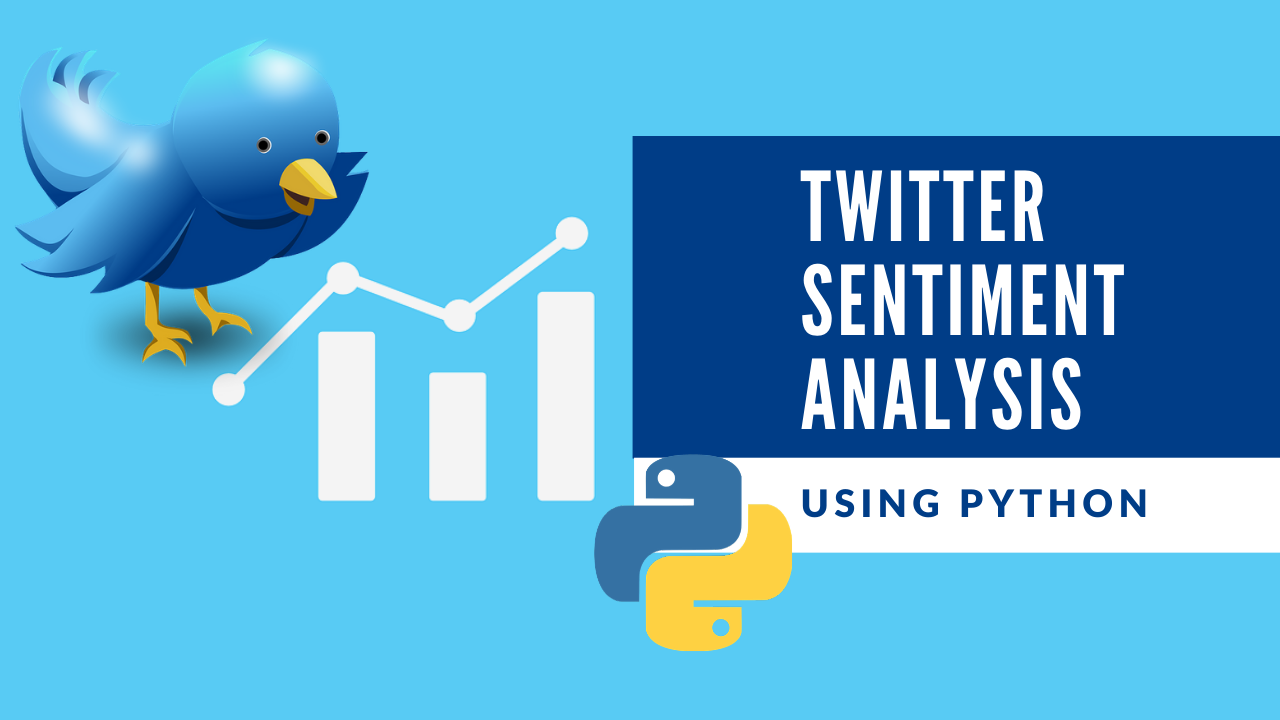

# Twitter Sentiment Analysis 

It is the process of computationally identifying and categorizing tweets expressed in a piece of text, especially in order to determine whether the writer’s attitude towards a particular topic, product, etc. is positive, negative, or neutral.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Sentiment.csv')
#Keeping only the necessary columns

data = data[['text','sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


#### For this particular analysis I dropped the neutral tweets, as my goal was to only differentiate positive and negative tweets.

In [3]:
# Splitting the dataset into train and test set
train, test = train_test_split(data, test_size=0.1)

#Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

As a next step I separated the Positive and Negative tweets of the training set in order to easily visualize their contained words.

After that I cleaned the text from hashtags, mentions and links. Now they were ready for a WordCloud visualization which shows only the most emphatic words of the Positive and Negative tweets.

Positive Words


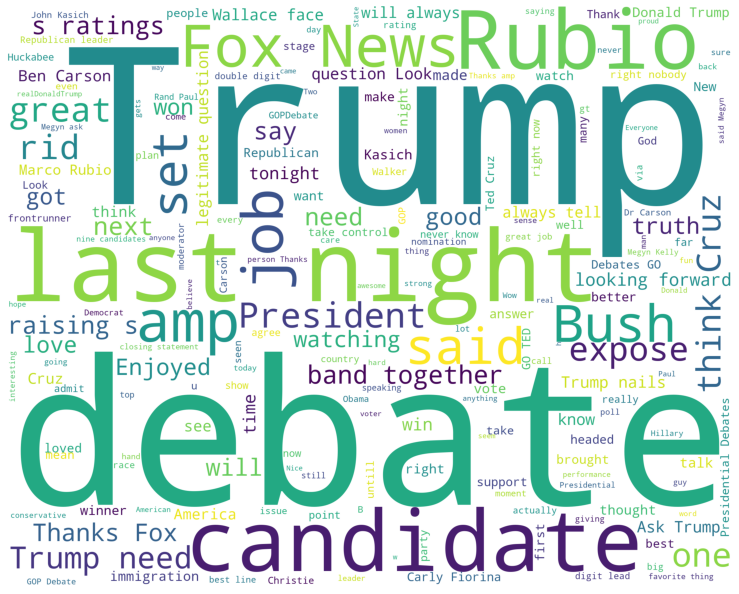

Negative Words


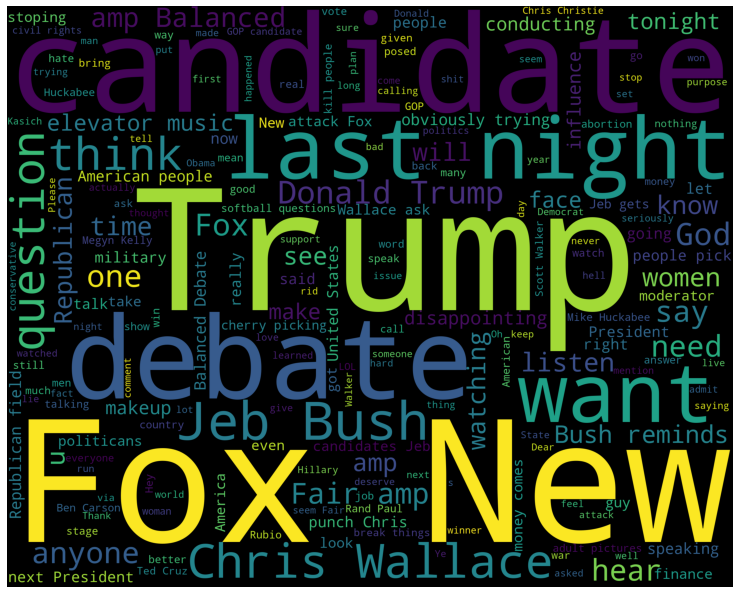

In [4]:
train_pos = train[train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color='black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                            and not word.startswith('@')
                            and not word.startswith('#')
                            and word != 'RT'])
    
    wordcloud = WordCloud(stopwords=STOPWORDS,
                         background_color=color,
                         width=2500,
                         height=2000
                         ).generate(cleaned_word)
    
    plt.figure(1, figsize=(13,13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive Words")
wordcloud_draw(train_pos,'white')
print("Negative Words")
wordcloud_draw(train_neg)

Stop Word: Stop Words are words which do not contain important significance to be used in Search Queries.

Usually these words are filtered out from search queries because they return vast amount of unnecessary information. ( the, for, this etc. )

In [5]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
                    if 'http' not in word
                    and not word.startswith('@')
                    and not word.startswith('#')
                    and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))
    
test_pos = test[test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[test['sentiment'] == 'Negative']
test_neg = test_neg['text']

I extracted the so called features with nltk lib, first by measuring a frequent distribution and by selecting the resulting keys.

In [7]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for(words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

I plotted the most frequently distributed words. The most words are centered around debate nights.

Using the nltk NaiveBayes Classifier I classified the extracted tweet word features.

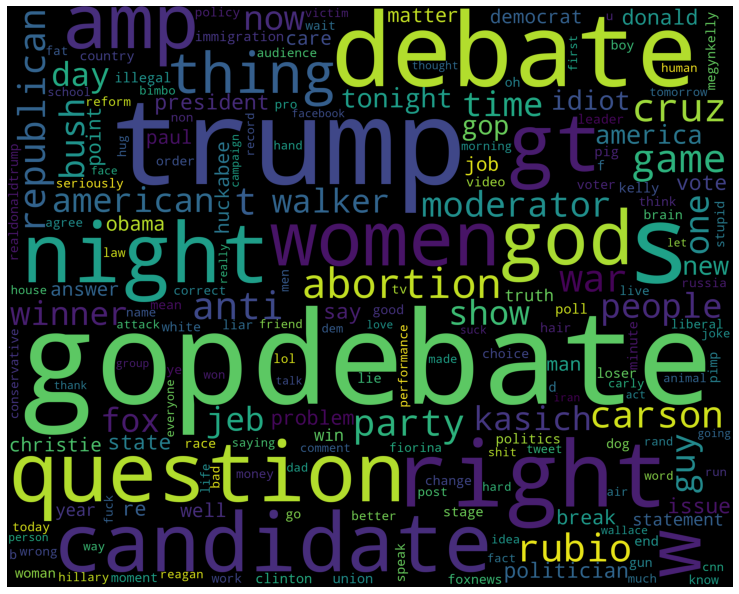

In [8]:
wordcloud_draw(w_features)

# Training the Naive Bayes Classifier
training_set = nltk.classify.apply_features(extract_features, tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

Finally, with not-so-intelligent metrics, I tried to measure how the classifier algorithm scored.

In [9]:
neg_cnt = 0
pos_cnt = 0

for obj in test_neg:
    res = classifier.classify(extract_features(obj.split()))
    if(res=='Negative'):
        neg_cnt = neg_cnt +1
        
for obj in test_pos:
    res = classifier.classify(extract_features(obj.split()))
    if(res=='Positive'):
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s ' % (len(test_neg), neg_cnt))
print('[Positive]: %s/%s ' % (len(test_pos), pos_cnt))

[Negative]: 866/807 
[Positive]: 223/84 
